In [9]:
import cv2
import numpy as np
import glob

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 一些基本函数

In [120]:
# 将图像分块，分成 n*n，仅适用于长宽一致的图像
def divide_img(image, interval):
    h, w = image.shape
    assert h == w, "The height != width."
    
    end = h // interval
    subs = []

    for i in range(end):
        for j in range(end):
            sub = image[interval*i:interval*(i+1),interval*j:interval*(j+1)]
            subs.append(sub)
    return subs

# 将图像合并，合并 n*n，仅适用于长宽一致的图像
def merge_image(sub_images, image, interval):
    h, w = image.shape
    new_image = np.zeros((h, w))
    end = h // interval
    num = 0
    for i in range(end):
        for j in range(end):
            new_image[interval*i:interval*(i+1),interval*j:interval*(j+1)] = sub_images[num]
            num += 1
    return new_image

def compute_psnr(img_in, img_sam):
    assert img_in.shape == img_sam.shape, "The sample image's shape is not same as the input!"
    
    mse = np.mean( (img_in/255. - img_sam/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    return 20 * np.log10(1 / np.sqrt(mse))

def merge_dct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.dct(sub_image)
        res.append(temp_dct)
    return np.array(res)

def merge_idct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.idct(sub_image)
        res.append(temp_dct)
    return np.array(res)

## 实验要求

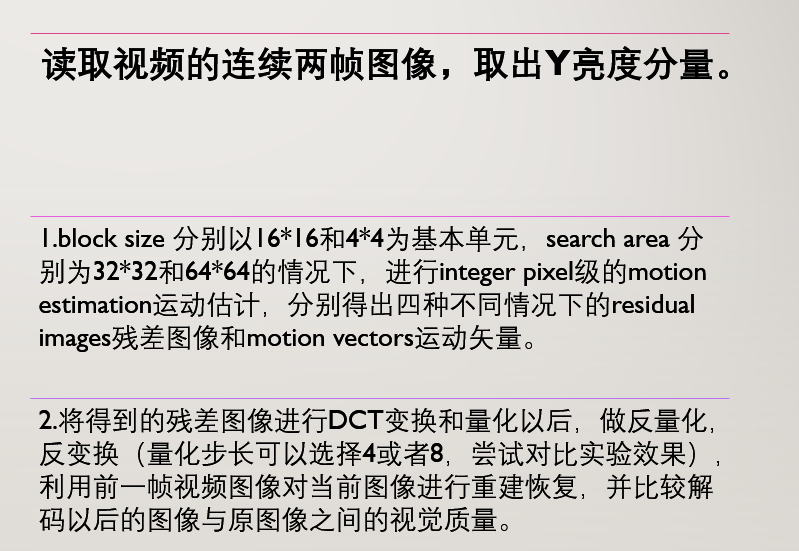

## 1. 截取两帧图像

In [2]:
video_full_path="./videoData/data.flv"
cap  = cv2.VideoCapture(video_full_path)
print(cap.isOpened())

num = 1
for _ in range(2):
    success, frame = cap.read()
 
    params = []
    params.append(1)
    cv2.imwrite(f"videoData/capture_{num}.jpg", frame, params)
 
    num += 1

cap.release()

True


## 2. 读取图像

### 2.1 显示两帧图像

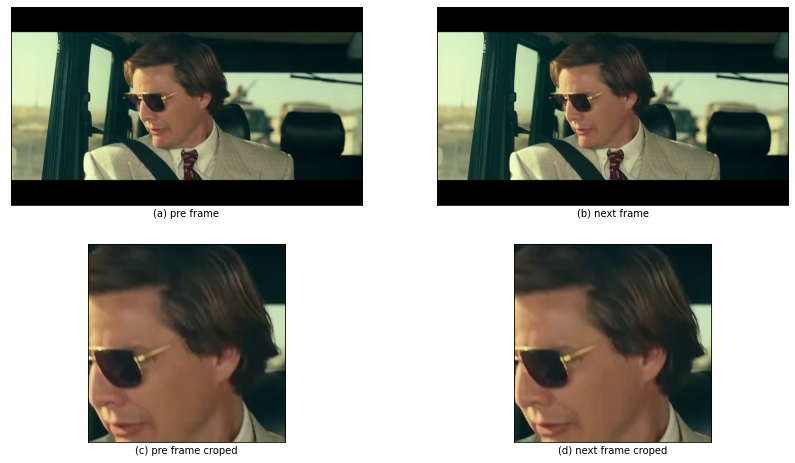

In [175]:
image_files = glob.glob('./videoData/*.jpg')
capture_1_ori = cv2.imread(image_files[0])
capture_2_ori = cv2.imread(image_files[1])

capture_1 = capture_1_ori[200:712, 700:1212]
capture_2 = capture_2_ori[200:712, 700:1212]

plt.figure(figsize=(14,8))

plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame')
plt.imshow(capture_1_ori[...,::-1])

plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) next frame')
plt.imshow(capture_2_ori[...,::-1])

plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) pre frame croped')
plt.imshow(capture_1[...,::-1])

plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) next frame croped')
plt.imshow(capture_2[...,::-1])

In [176]:
width, height, channel = capture_1.shape
print(f'The shape of image is {capture_1.shape}')

The shape of image is (512, 512, 3)


### 2.2 显示转换为YCrCb后的Y通道图像

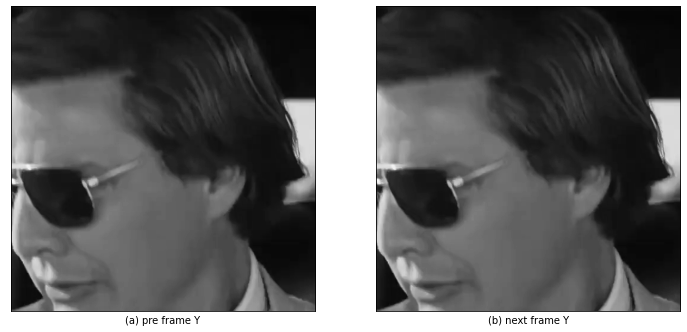

In [177]:
capture_1_Ycrcb = cv2.cvtColor(capture_1, cv2.COLOR_BGR2YCrCb)
capture_2_Ycrcb = cv2.cvtColor(capture_2, cv2.COLOR_BGR2YCrCb)

capture_1_Y, capture_1_Cb, capture_1_Cr = cv2.split(capture_1_Ycrcb)
capture_2_Y, capture_2_Cb, capture_2_Cr = cv2.split(capture_2_Ycrcb)

plt.figure(figsize=(12,6))

plt.subplot(121)
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame Y')
plt.imshow(capture_1_Y, cmap='gray')

plt.subplot(122)
plt.xticks([])
plt.yticks([])
# plt.axis('off')
plt.xlabel('(b) next frame Y')
plt.imshow(capture_2_Y, cmap='gray')

---

In [178]:
capture_1_Y.shape

(512, 512)

## 3. 运动估计

### 3.1 构造矩阵，用于遍历

In [181]:
# block_sizes = 4
# search_areas = 32

# interval = (search_areas-block_sizes)//2
# mask_image_1 = np.zeros((width + interval*2, height + interval*2))
# mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y

# mask_width, mask_height = mask_image_1.shape
# # mask_image_1.shape,
# print(mask_image_1)

In [182]:
def mse(x, y):
    return np.linalg.norm(x - y)

In [183]:
len(motion_vectors) == (width//block_sizes) * (height // block_sizes)

True

### 3.2 获取预测图像以及运动矢量

In [255]:
def get_preimage_motions(width, height, block_sizes, search_areas):

    width_num = width // block_sizes
    height_num = height // block_sizes
    # 运动向量个数
    vet_nums = width_num * height_num
    # 用来保存运动向量，保存坐标值
    motion_vectors = []
    # 先赋予空值
    motion_vectors = [[0, 0] for _ in range(vet_nums)]
    motion_vectors_for_draw = [[0, 0, 0, 0] for _ in range(vet_nums)]
    
    similarity = 0
    num = 0
    end_num = search_areas//block_sizes
    
    # 计算间隔，用于补0
    interval = (search_areas-block_sizes)//2
    # 构造模板图像，对于上一帧图像加0
    mask_image_1 = np.zeros((width + interval*2, height + interval*2))
    mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y

    mask_width, mask_height = mask_image_1.shape

    predict_image = np.zeros(capture_1_Y.shape)    
    
#     count = 0
    for i in range(height_num):
        for j in range(width_num):
#             count += 1
    #         print(f'==================i:{i}=j:{j}==count:{count}=====================')
            temp_image = capture_2_Y[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes]
            mask_image = mask_image_1[i*block_sizes:i*block_sizes+search_areas, j*block_sizes:j*block_sizes+search_areas]
            #  给定初值，用于比较
            temp_res = mse(mask_image[:block_sizes, :block_sizes], temp_image)
            for k in range(end_num):
                for h in range(end_num):
                    # 取一个模板
                    temp_mask = mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes]
                    # 计算mse
                    res = mse(temp_mask, temp_image)
                    # 比较，如果大于默认值，则将其设为默认值，并将预测图像赋值，替代当前运动矢量
                    if res <= temp_res:
                        temp_res = res
                        motion_vectors[i*j+j][0], motion_vectors[i*j+j][1] = (h,k), (interval/block_sizes, interval/block_sizes)
                        motion_vectors_for_draw[i*j+j][0], motion_vectors_for_draw[i*j+j][1], motion_vectors_for_draw[i*j+j][2], motion_vectors_for_draw[i*j+j][3] = i+k, height_num-(j+h), i+interval/block_sizes, height_num-(j+interval/block_sizes)
                        predict_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_mask
#                         print(motion_vectors_for_draw[i*j+j])
    #                 break
    #             break
#             break
#         break
    return np.array(predict_image), np.array(motion_vectors), np.array(motion_vectors_for_draw)

1. block_sizes = 4, search_areas = 32

In [262]:
predict_image_4_32, motion_vectors_4_32, motion_vectors_for_draw_4_32 = get_preimage_motions(width, height, 4, 32)

2. block_sizes = 4, search_areas = 64

In [307]:
predict_image_4_64, motion_vectors_4_64, motion_vectors_for_draw_4_64 = get_preimage_motions(width, height, 4, 64)

3. block_sizes = 16, search_areas = 32

In [308]:
predict_image_16_32, motion_vectors_16_32, motion_vectors_for_draw_16_32 = get_preimage_motions(width, height, 16, 32)

4. block_sizes = 16, search_areas = 64

In [296]:
predict_image_16_64, motion_vectors_16_64, motion_vectors_for_draw_16_64 = get_preimage_motions(width, height, 16, 64)

In [297]:
motion_vectors_for_draw_16_64[-10:]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### 3.3 绘制运动矢量

保存的向量还是有些小问题，待改正...

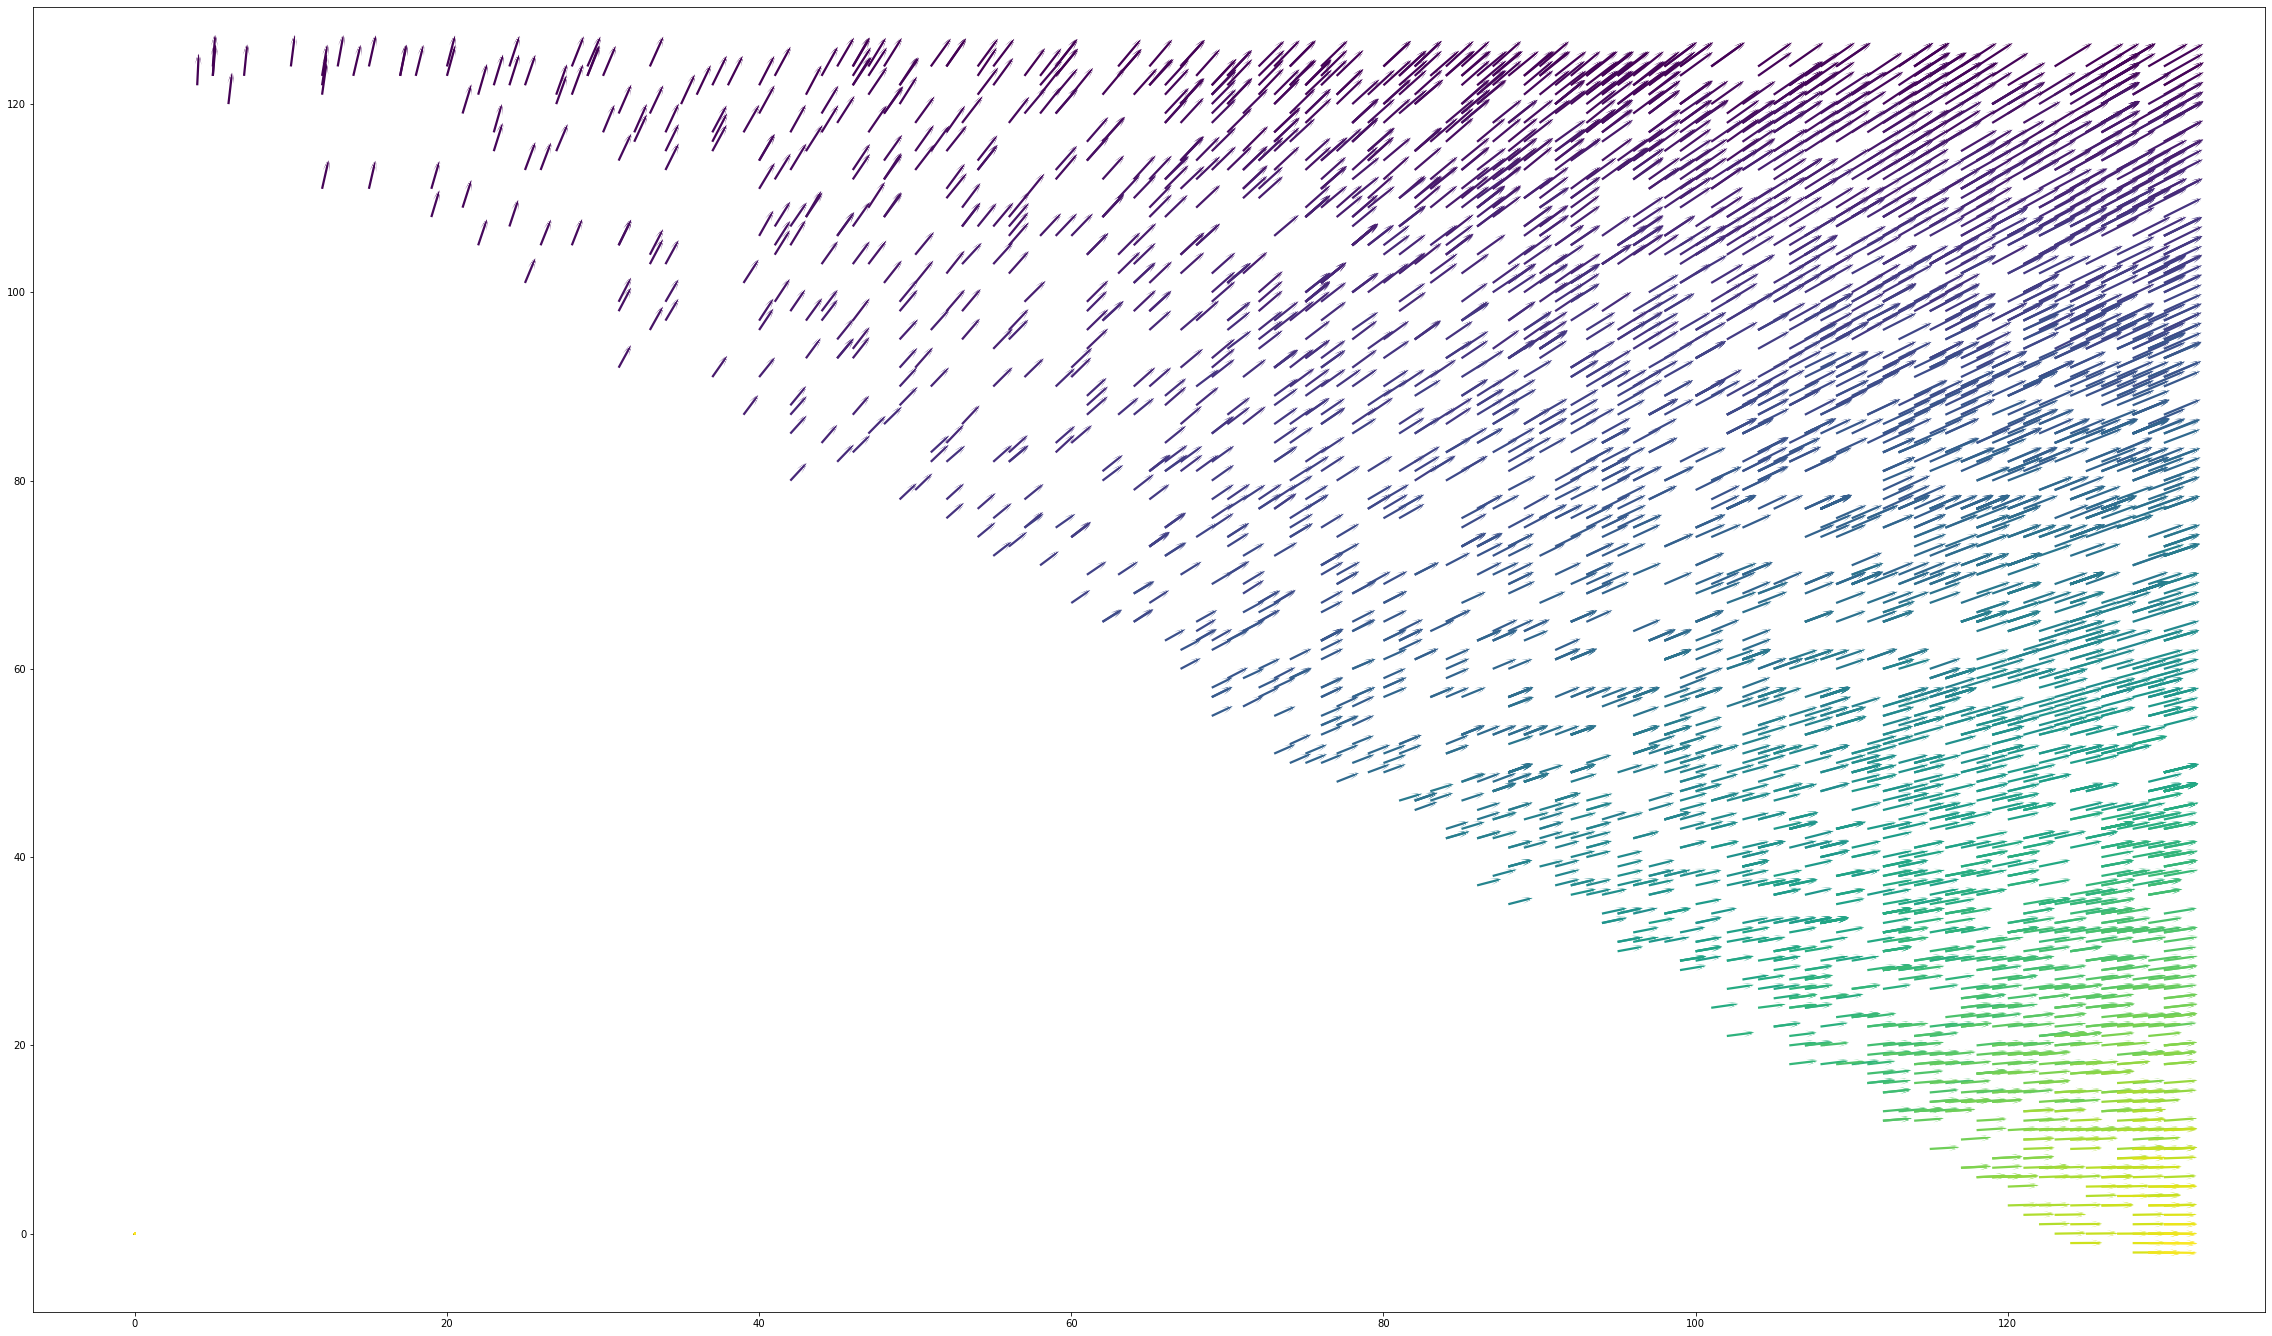

In [306]:
X, Y, U, V = zip(*motion_vectors_for_draw_4_32) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_4_32))
ax.quiver(X, Y, U, V, c, angles='xy', headaxislength=0.6, width=0.001) 
plt.draw() 
plt.show()

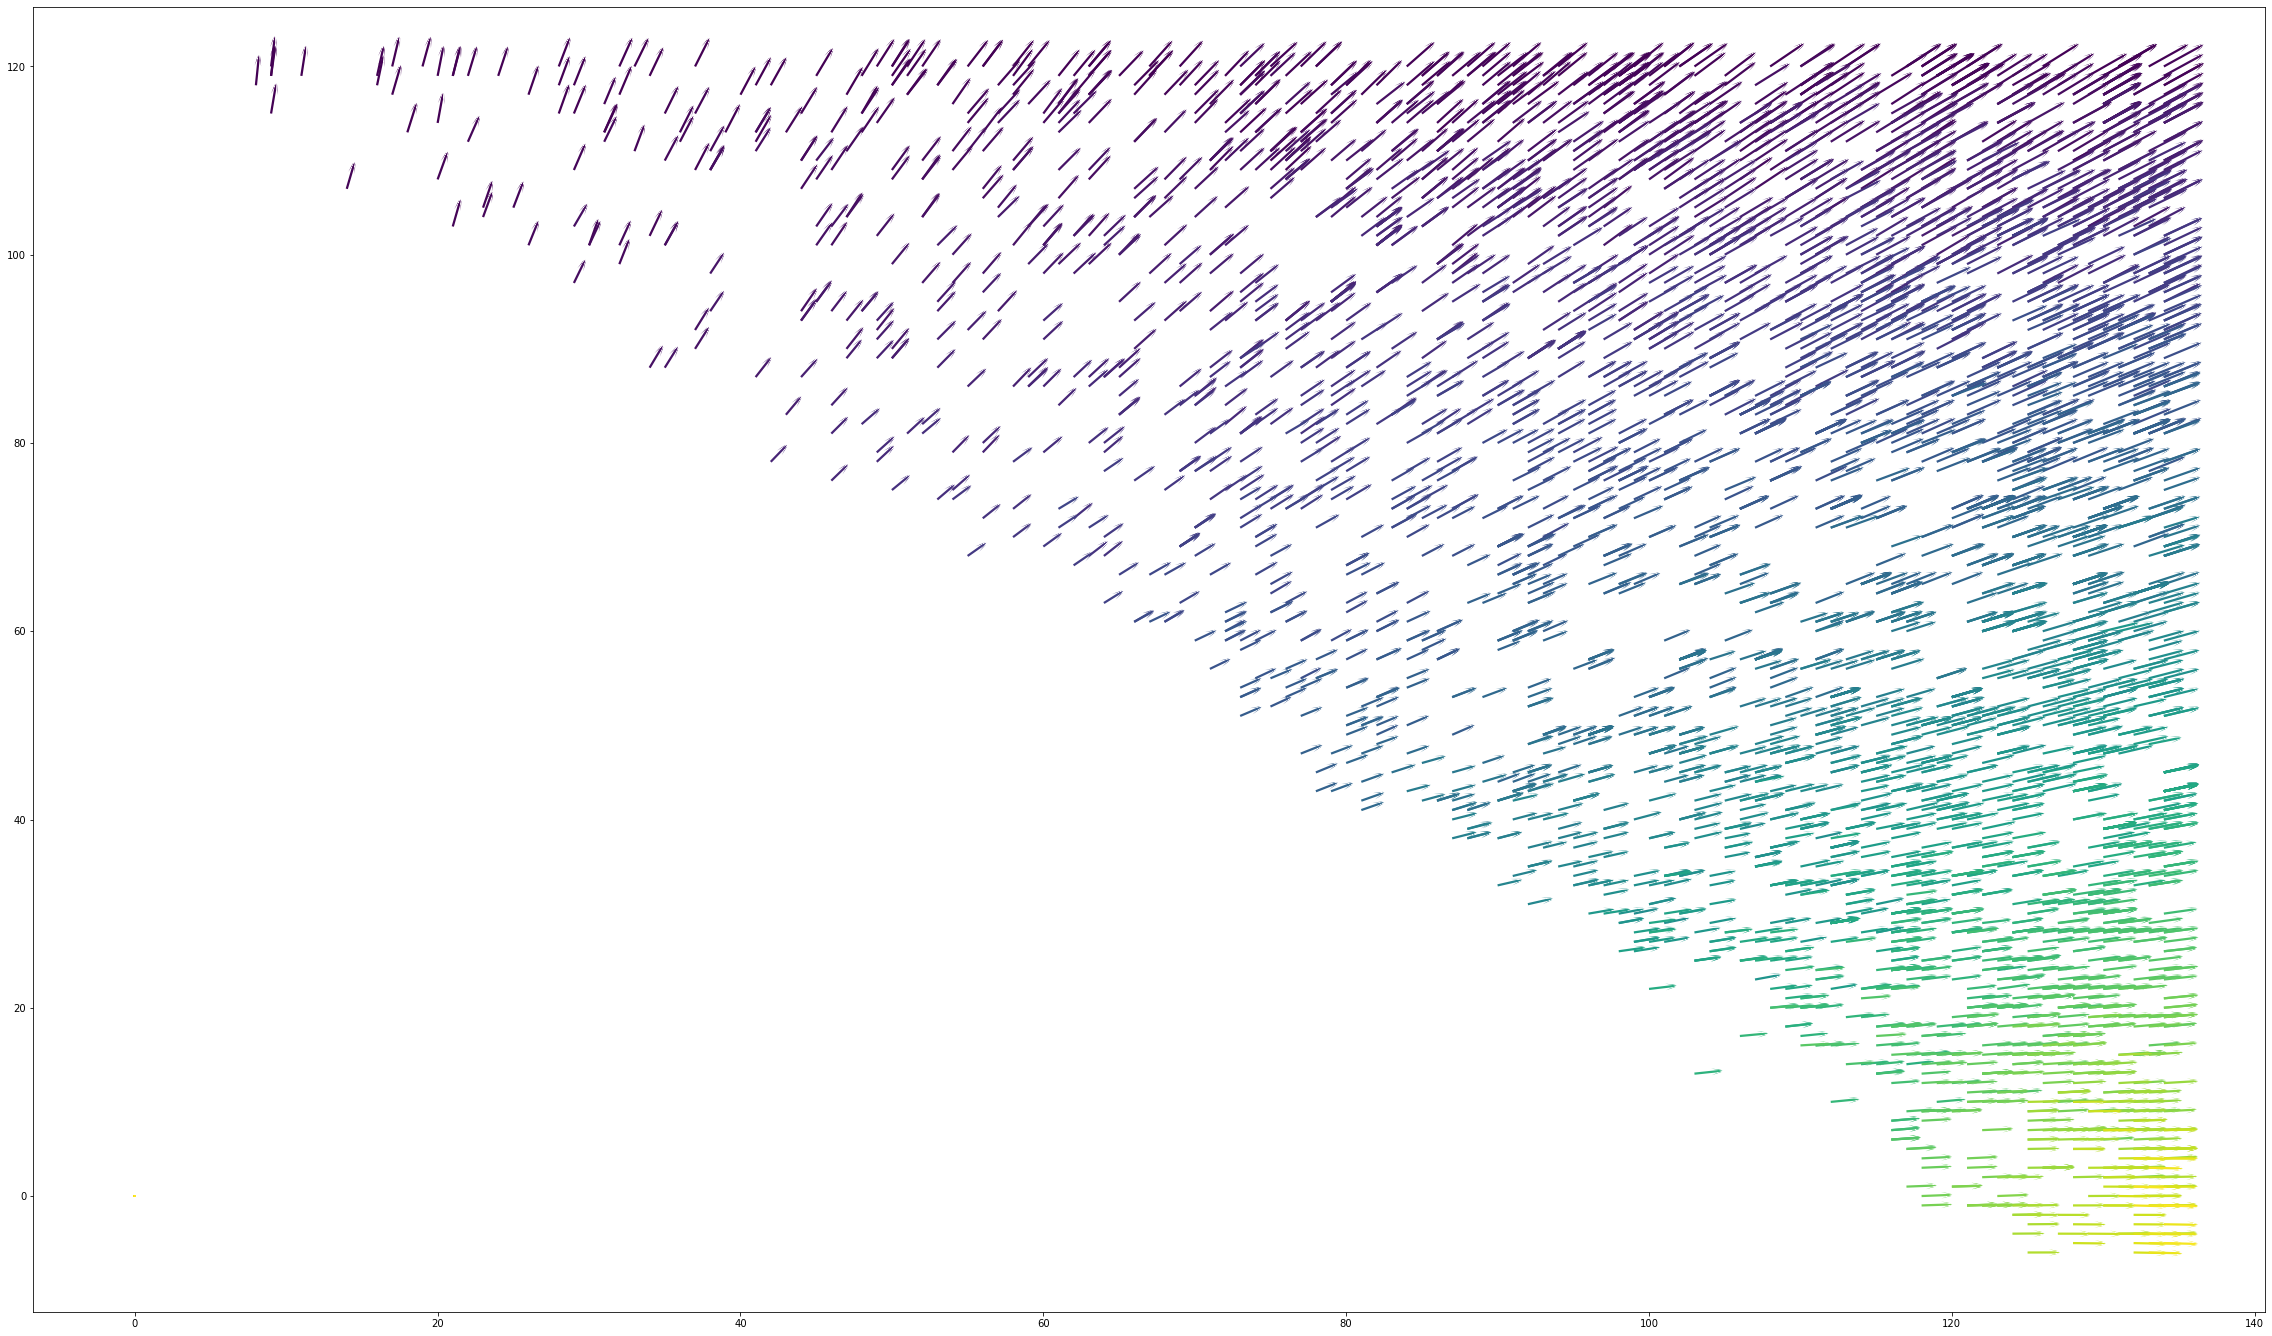

In [309]:
X, Y, U, V = zip(*motion_vectors_for_draw_4_64) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_4_64))
ax.quiver(X, Y, U, V, c, angles='xy', headaxislength=0.4, width=0.001) 
plt.draw() 
plt.show()

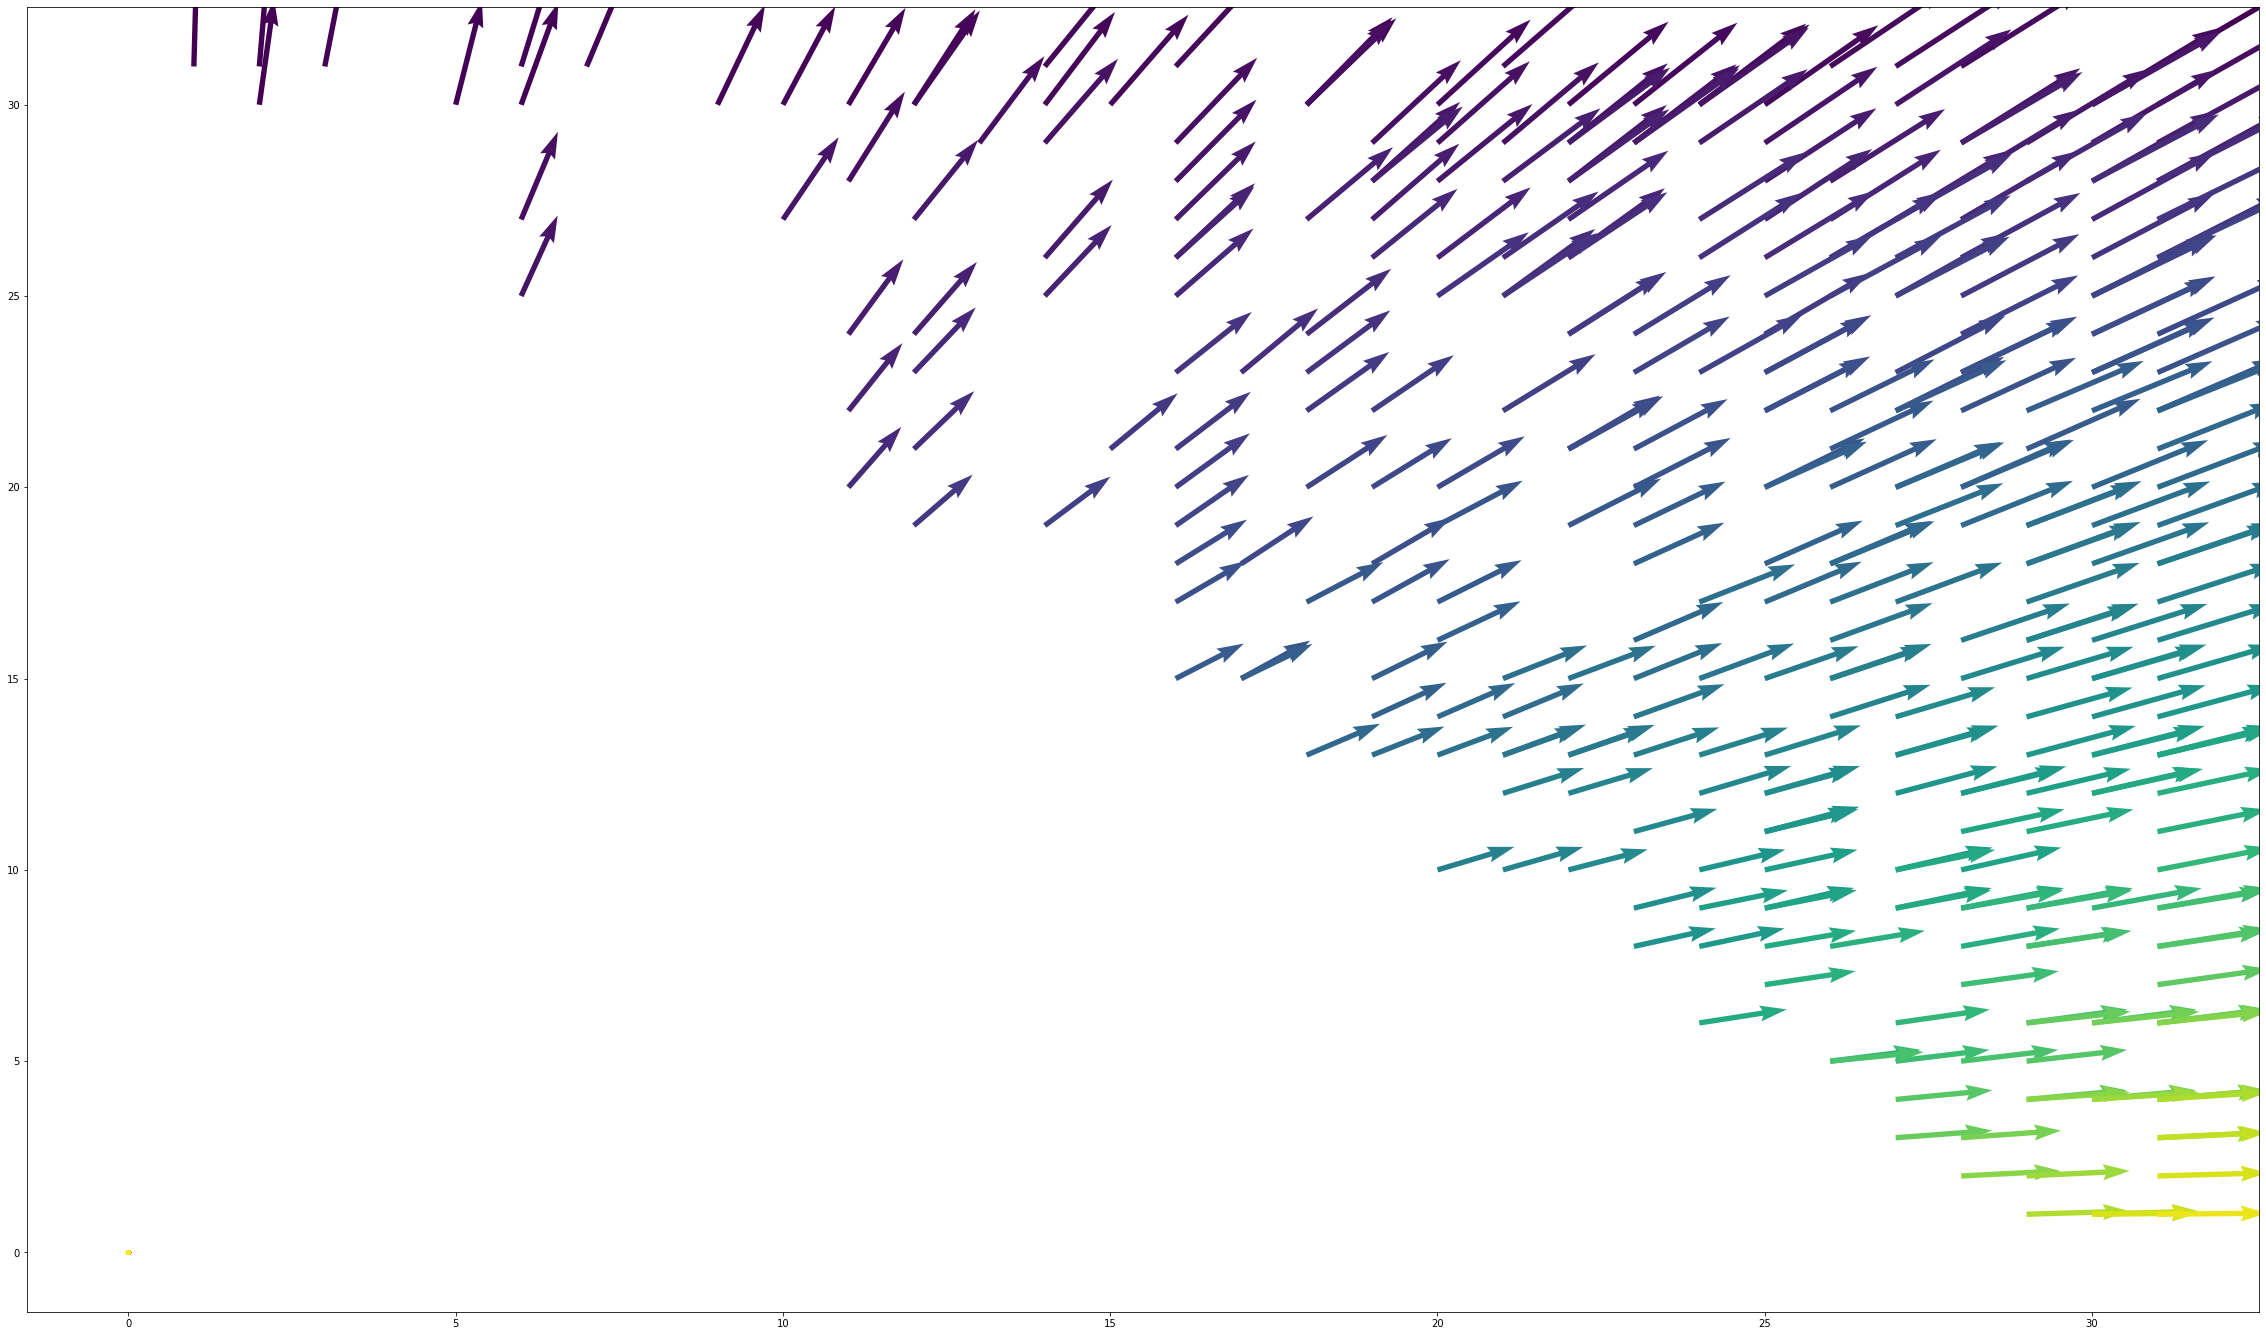

In [310]:
X, Y, U, V = zip(*motion_vectors_for_draw_16_32) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_16_32))
ax.quiver(X, Y, U, V, c, angles='xy') 
plt.draw() 
plt.show()

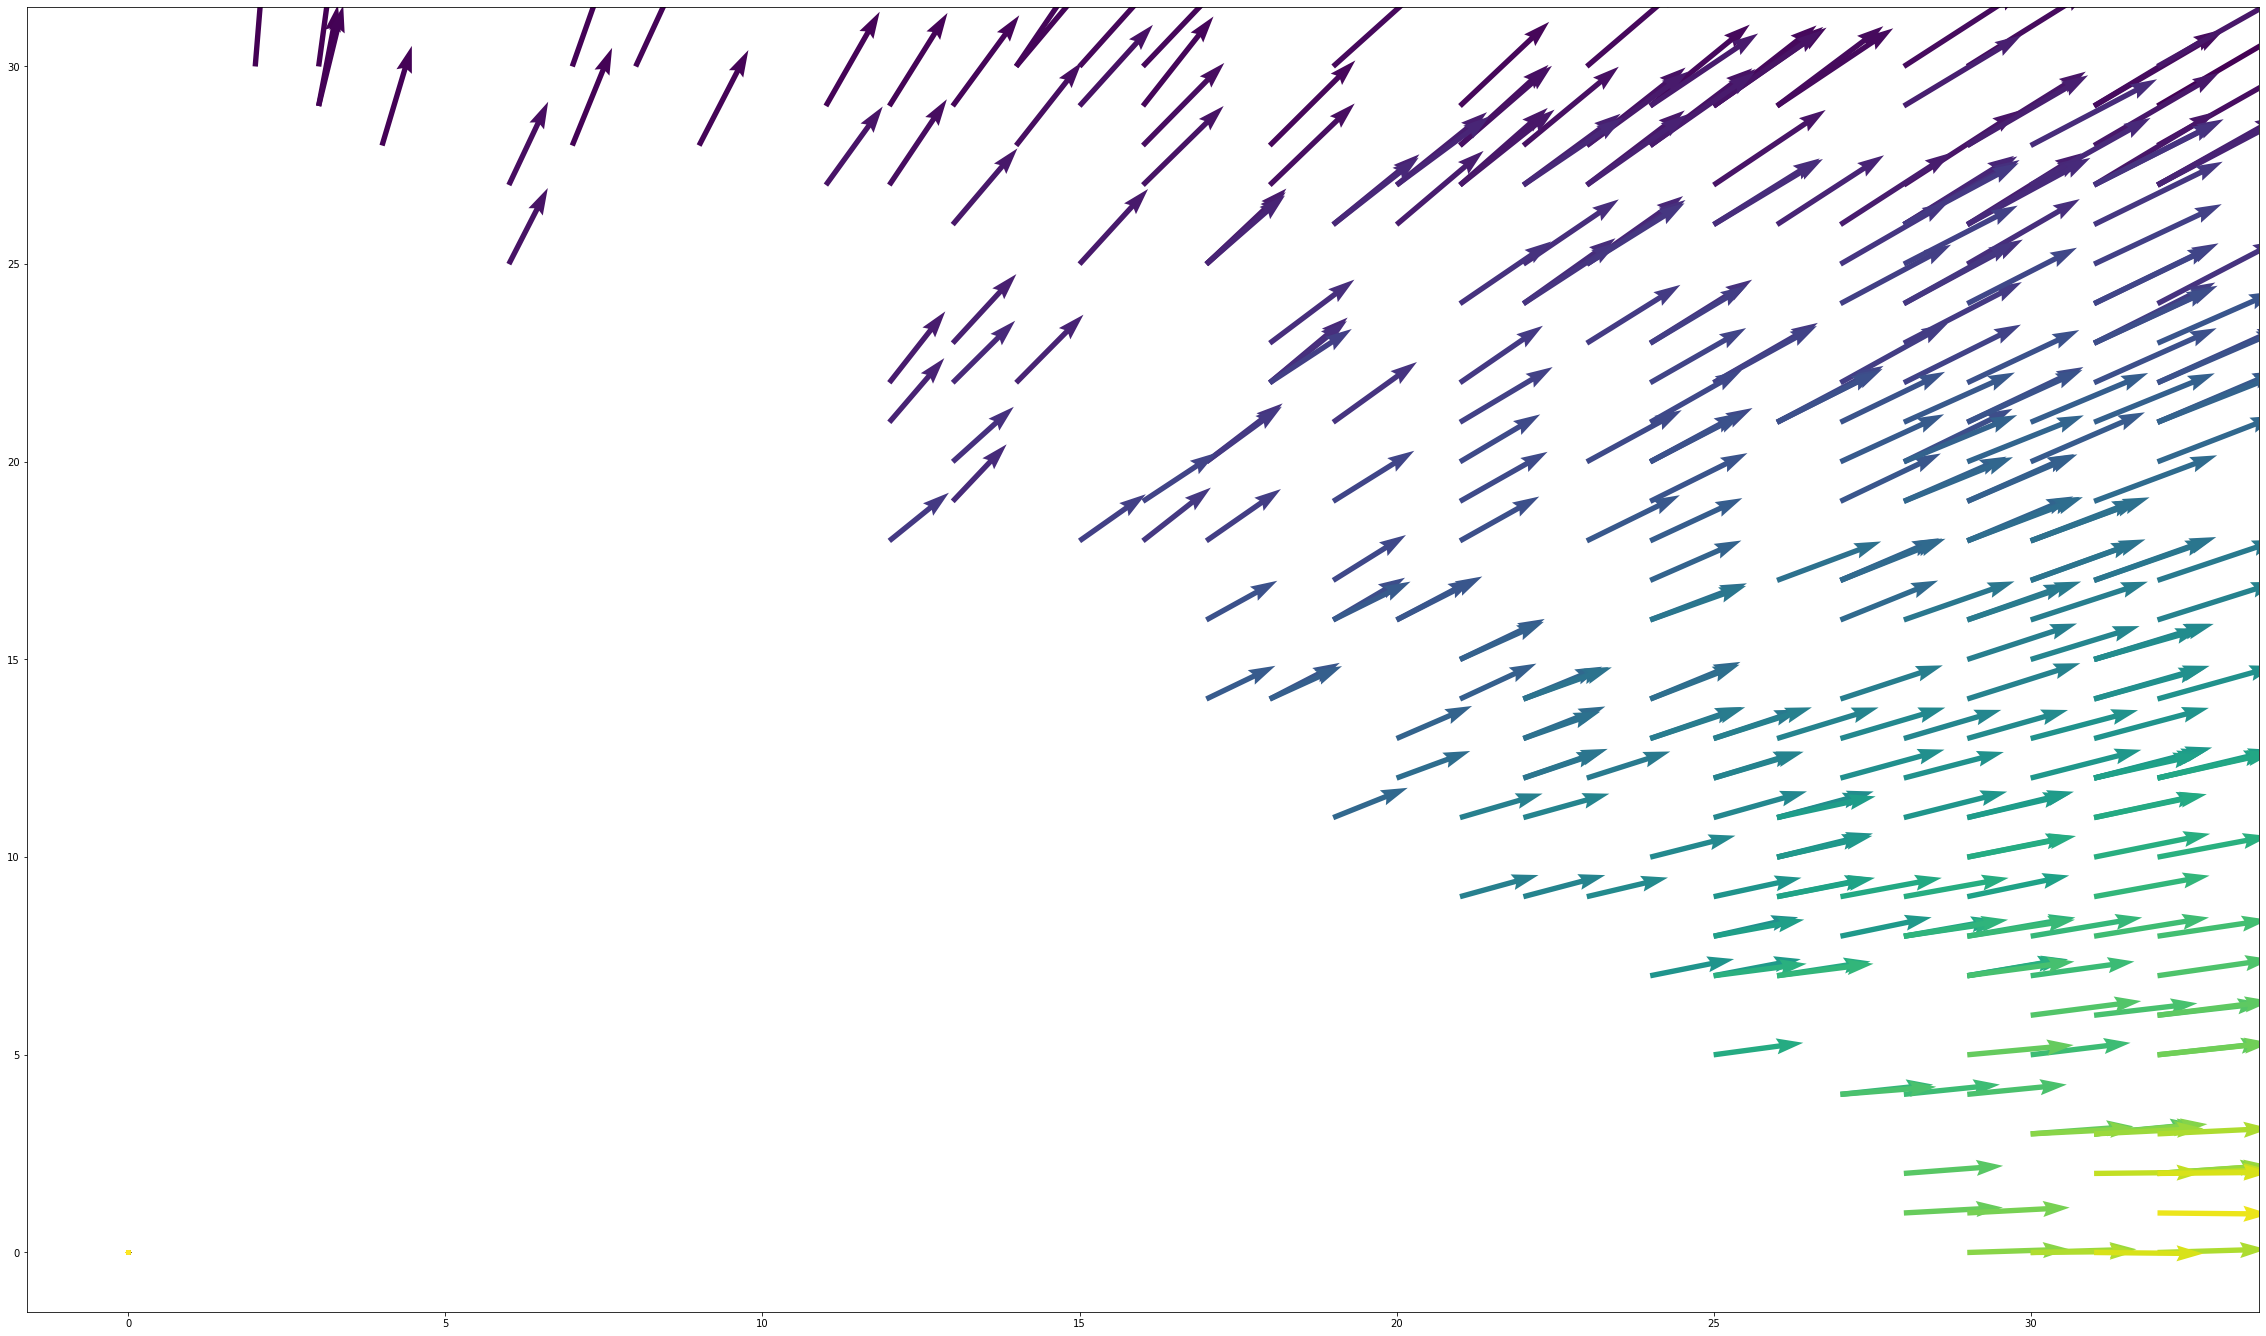

In [318]:
X, Y, U, V = zip(*motion_vectors_for_draw_16_64) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_16_64))
ax.quiver(X, Y, U, V, c, angles='xy') 
plt.draw() 
plt.show()

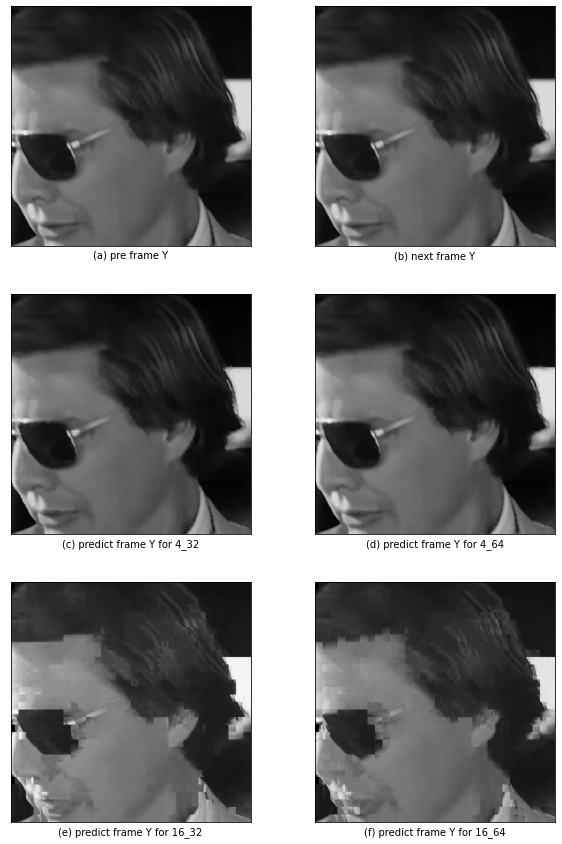

In [333]:
plt.figure(figsize=(10,15))

plt.subplot(321)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame Y')
plt.imshow(capture_1_Y, cmap='gray')

plt.subplot(322)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) next frame Y')
plt.imshow(capture_2_Y, cmap='gray')

plt.subplot(323)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) predict frame Y for 4_32')
plt.imshow(predict_image_4_32, cmap='gray')

plt.subplot(324)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) predict frame Y for 4_64')
plt.imshow(predict_image_4_64, cmap='gray')

plt.subplot(325)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_32')
plt.imshow(predict_image_16_32, cmap='gray')

plt.subplot(326)
plt.xticks([])
plt.yticks([])
plt.xlabel('(f) predict frame Y for 16_64')
plt.imshow(predict_image_16_64, cmap='gray')

### 3.2 得到残差图像

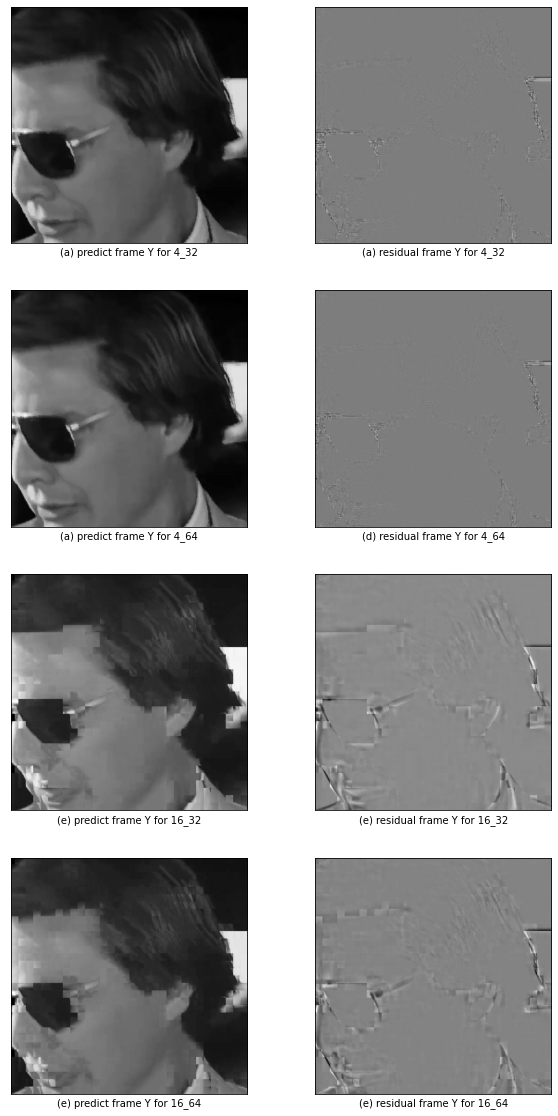

In [243]:
residual_image_4_32 = np.array(predict_image_4_32 - capture_2_Y)
residual_image_4_64 = np.array(predict_image_4_64 - capture_2_Y)
residual_image_16_32 = np.array(predict_image_16_32 - capture_2_Y)
residual_image_16_64 = np.array(predict_image_16_64 - capture_2_Y)

plt.figure(figsize=(10,20))
plt.subplot(421)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) predict frame Y for 4_32')
plt.imshow(predict_image_4_32, cmap='gray')

plt.subplot(422)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) residual frame Y for 4_32')
plt.imshow(residual_image_4_32, cmap='gray')

plt.subplot(423)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) predict frame Y for 4_64')
plt.imshow(predict_image_4_64, cmap='gray')

plt.subplot(424)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) residual frame Y for 4_64')
plt.imshow(residual_image_4_64, cmap='gray')

plt.subplot(425)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_32')
plt.imshow(predict_image_16_32, cmap='gray')

plt.subplot(426)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) residual frame Y for 16_32')
plt.imshow(residual_image_16_32, cmap='gray')

plt.subplot(427)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_64')
plt.imshow(predict_image_16_64, cmap='gray')

plt.subplot(428)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) residual frame Y for 16_64')
plt.imshow(residual_image_16_64, cmap='gray')

In [198]:
residual_image_4_32

array([[ 0., -1., -1., ...,  0.,  0.,  0.],
       [ 2.,  1., -1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  2., ...,  0.,  0.,  0.],
       ...,
       [-2., -2.,  1., ...,  0., -3., -4.],
       [ 5.,  5.,  1., ...,  0., -1., -3.],
       [16., 15., 14., ..., -1., -2., -2.]])

In [199]:
sub_image_y_4_32 = divide_img(residual_image_4_32, 4)
sub_image_y_4_32[0]

array([[ 0., -1., -1., -1.],
       [ 2.,  1., -1., -1.],
       [ 1.,  1.,  2.,  2.],
       [ 1.,  0.,  0.,  0.]])

*坐上角的值不是最大值*

In [200]:
sub_image_y_4_32 = [np.float32(i) for i in sub_image_y_4_32]
y_dct_4_32_no_array = merge_dct(sub_image_y_4_32)
y_dct_4_32_no_array[0]

array([[ 1.25      ,  1.4418621 ,  0.75      ,  0.21455535],
       [-1.9830582 ,  0.92677677,  0.13529903, -0.23743689],
       [-2.25      , -0.13529903,  0.25      ,  0.32664075],
       [ 1.0920076 , -2.237437  , -0.32664075,  0.57322335]],
      dtype=float32)

*使用反变换进行测试后发现可以复原*

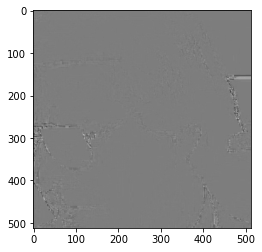

In [250]:
ori_img_recover = merge_idct(y_dct_4_32_no_array)
recover_img = merge_image(ori_img_recover, predict_image, 4)
plt.imshow(recover_img, cmap='gray')

---
# 基本原理

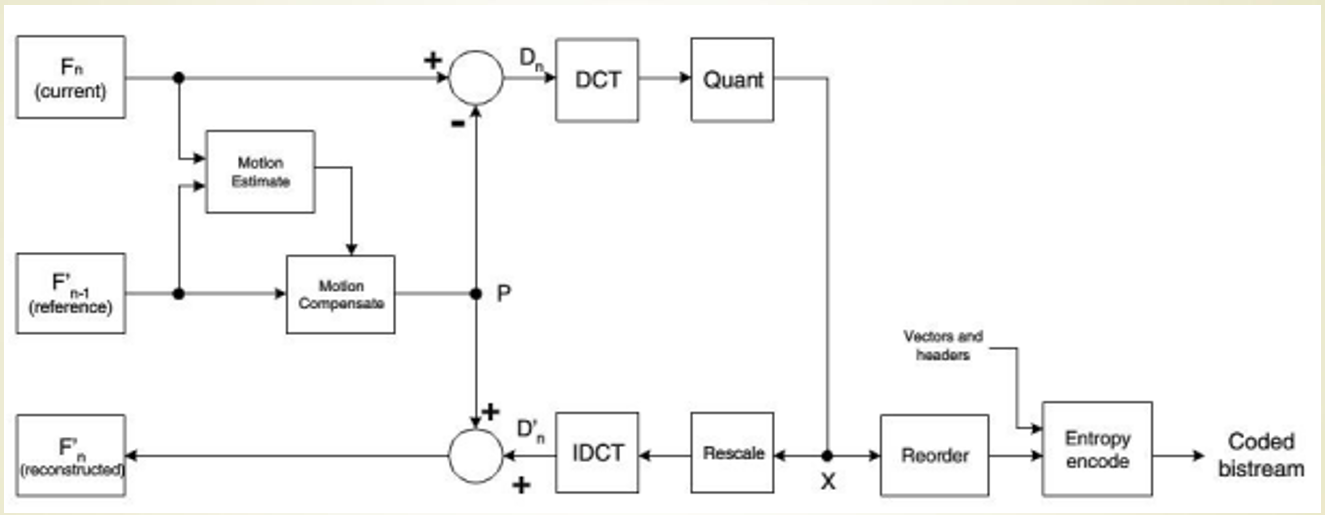

## 4. DCT

### 4.1 DCT变换

In [322]:
sub_image_y_4_32 = divide_img(residual_image_4_32, 4)
sub_image_y_4_64 = divide_img(residual_image_4_64, 4)
sub_image_y_16_32 = divide_img(residual_image_16_32, 4)
sub_image_y_16_64 = divide_img(residual_image_16_64, 4)

sub_image_y_4_32 = [np.float32(i) for i in sub_image_y_4_32]
y_dct_4_32_no_array = merge_dct(sub_image_y_4_32)

sub_image_y_4_64 = [np.float32(i) for i in sub_image_y_4_64]
y_dct_4_64_no_array = merge_dct(sub_image_y_4_64)

sub_image_y_16_32 = [np.float32(i) for i in sub_image_y_16_32]
y_dct_16_32_no_array = merge_dct(sub_image_y_16_32)

sub_image_y_16_64 = [np.float32(i) for i in sub_image_y_16_64]
y_dct_16_64_no_array = merge_dct(sub_image_y_16_64)

### 4.2 量化

观察数据后发现，如果除以4，大部分都会变成0，会影响图像数据，因此尝试用步长2量化

In [326]:
y_dct_4_32_no_array_qutisize_4 = np.round(y_dct_4_32_no_array / 4)
y_dct_4_64_no_array_qutisize_4 = np.round(y_dct_4_64_no_array / 4)
y_dct_16_32_no_array_qutisize_4 = np.round(y_dct_16_32_no_array / 4)
y_dct_16_64_no_array_qutisize_4 = np.round(y_dct_16_64_no_array / 4)

In [328]:
y_dct_16_64_no_array_qutisize_4[:10], y_dct_16_64_no_array

(array([[[-27.,   1.,   0.,  -0.],
         [ -2.,   0.,   0.,  -0.],
         [ -0.,  -0.,  -0.,   0.],
         [  0.,  -0.,  -0.,   0.]],
 
        [[-30.,   1.,   0.,  -0.],
         [ -2.,  -0.,  -0.,   0.],
         [ -0.,  -0.,  -0.,  -0.],
         [  0.,  -0.,   0.,   0.]],
 
        [[ -9.,   1.,  -0.,   0.],
         [ -2.,   0.,  -0.,   0.],
         [ -0.,   0.,  -0.,  -0.],
         [  0.,   0.,  -0.,   0.]],
 
        [[-10.,   0.,   0.,  -0.],
         [ -2.,   0.,   0.,  -0.],
         [ -0.,  -0.,   0.,   0.],
         [  0.,  -0.,   0.,   0.]],
 
        [[-12.,   1.,   0.,   1.],
         [ -1.,  -0.,   0.,  -0.],
         [ -0.,  -0.,  -0.,  -0.],
         [  0.,  -0.,  -0.,   0.]],
 
        [[-14.,  -2.,   0.,   0.],
         [  1.,   1.,   0.,  -1.],
         [ -0.,  -0.,   0.,  -0.],
         [  0.,  -0.,   0.,   0.]],
 
        [[-10.,  -1.,   1.,  -1.],
         [ -1.,   0.,   0.,   0.],
         [  0.,   0.,  -0.,  -0.],
         [  0.,   0.,  -0.,  -0.]],
 

In [331]:
y_dct_4_32_no_array_qutisize_2 = np.round(y_dct_4_32_no_array / 2)
y_dct_4_64_no_array_qutisize_2 = np.round(y_dct_4_64_no_array / 2)
y_dct_16_32_no_array_qutisize_2 = np.round(y_dct_16_32_no_array / 2)
y_dct_16_64_no_array_qutisize_2 = np.round(y_dct_16_64_no_array / 2)

In [332]:
y_dct_4_32_no_array_qutisize_8[:3], y_dct_4_32_no_array[:3]

(array([[[ 0.,  0.,  0.,  0.],
         [-0.,  0.,  0., -0.],
         [-0., -0.,  0.,  0.],
         [ 0., -0., -0.,  0.]],
 
        [[-0., -0.,  0.,  0.],
         [-0., -0.,  0.,  0.],
         [-0., -0., -0.,  0.],
         [ 0., -0.,  0.,  0.]],
 
        [[-0., -0., -0.,  0.],
         [-0.,  0., -0.,  0.],
         [-0.,  0., -0., -0.],
         [ 0., -0.,  0.,  0.]]], dtype=float32),
 array([[[ 1.25      ,  1.4418621 ,  0.75      ,  0.21455535],
         [-1.9830582 ,  0.92677677,  0.13529903, -0.23743689],
         [-2.25      , -0.13529903,  0.25      ,  0.32664075],
         [ 1.0920076 , -2.237437  , -0.32664075,  0.57322335]],
 
        [[-0.25      , -0.48515344,  0.75      ,  2.0951436 ],
         [-2.8276813 , -0.7803302 ,  0.32664075,  0.67677677],
         [-2.25      , -1.2505203 , -1.25      ,  0.24738449],
         [ 0.35946983, -0.32322332,  0.13529903,  0.2803301 ]],
 
        [[-2.        , -0.0792563 , -0.5       ,  1.1152213 ],
         [-2.5010407 ,  1.10355

### 4.3 反量化

### 4.4 反变换

## 5. 重建

---

#### 网上找的还没详细理解……

In [29]:
capture = cv2.VideoCapture(video_full_path)

nbFrames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

fps = capture.get(cv2.CAP_PROP_FPS)
wait = int(1/fps * 1000/1)

width, height = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# nbFrames, fps, width, height

prev_gray = np.zeros((width, height,1),np.uint8)
gray = np.zeros((width, height, 1), np.uint8) # Will hold the current frame

# 有错
prevPyr = np.zeros((height // 3, width + 8, 1), np.uint8)
currPyr = np.zeros((height // 3, width + 8, 1), np.uint8)

In [ ]:
max_count = 500
qLevel= 0.01
minDist = 10
prev_points = [] #Points at t-1
curr_points = [] #Points at t
lines=[] #To keep all the lines overtime
 
for f in range(nbFrames):
 
    frame = cv2.QueryFrame(capture) #Take a frame of the video
 
    cv2.cv2tColor(frame, gray, cv2.cv2_BGR2GRAY) #Convert to gray
    output = cv2.CloneImage(frame)
 
    prev_points = cv2.GoodFeaturesToTrack(gray, None, None, max_count, qLevel, minDist) #Find points on the image
 
    #Calculate the movement using the previous and the current frame using the previous points
    curr_points, status, err = cv2.CalcOpticalFlowPyrLK(prev_gray, gray, prevPyr, currPyr, prev_points, (10, 10), 3, (cv2.cv2_TERMCRIT_ITER|cv2.cv2_TERMCRIT_EPS,20, 0.03), 0)
 
 
    #If points status are ok and distance not negligible keep the point
    k = 0
    for i in range(len(curr_points)):
        nb =  abs( int(prev_points[i][0])-int(curr_points[i][0]) ) + abs( int(prev_points[i][1])-int(curr_points[i][1]) )
        if status[i] and  nb > 2 :
            prev_points[k] = prev_points[i]
            curr_points[k] = curr_points[i]
            k += 1
 
    prev_points = prev_points[:k]
    curr_points = curr_points[:k]
    #At the end only interesting points are kept
 
    #Draw all the previously kept lines otherwise they would be lost the next frame
    for (pt1, pt2) in lines:
        cv2.Line(frame, pt1, pt2, (255,255,255))
 
    #Draw the lines between each points at t-1 and t
    for prevpoint, point in zip(prev_points,curr_points):
        prevpoint = (int(prevpoint[0]),int(prevpoint[1]))
        cv2.Circle(frame, prevpoint, 15, 0)
        point = (int(point[0]),int(point[1]))
        cv2.Circle(frame, point, 3, 255)
        cv2.Line(frame, prevpoint, point, (255,255,255))
        lines.append((prevpoint,point)) #Append current lines to the lines list
 
 
    cv2.Copy(gray, prev_gray) #Put the current frame prev_gray
    prev_points = curr_points
 
    cv2.ShowImage("The Video", frame)
    #cv2.WriteFrame(writer, frame)
    cv2.WaitKey(wait)